In [30]:
import networkx as nx
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [31]:
#final_dataframes = pickle.load(open("final_dataframes.pkl", "rb"))
final_dataframes = pickle.load(open("data_prep/four_days_data.pkl", "rb"))

In [32]:
# Define the train ratio
train_ratio = 0.7  # 80% training data
lookback = 50
pred_horizon = 1
df_dict = final_dataframes

# Split each DataFrame into training and testing parts based on time
df_dict_train = {}
df_dict_test = {}
for key, df in final_dataframes.items():
    n_time_steps = len(df['traffic_flow'])
    train_size = int(n_time_steps * train_ratio)
    df_train = df.iloc[:train_size].copy()
    df_test = df.iloc[train_size:].copy()
    df_dict_train[key] = df_train
    df_dict_test[key] = df_test


def create_sliding_window_data(df_dict, lookback, pred_horizon):
    X_dict = {}
    y_dict = {}
    for key, df in df_dict.items():
        node_series = df['traffic_flow'].values
        X_node = []
        y_node = []
        for i in range(len(node_series) - lookback - pred_horizon + 1):
            X_node.append(node_series[i:i + lookback])  # Input: Lookback window
            y_node.append(node_series[i + lookback:i + lookback + pred_horizon])  # Output: Next step(s)
        X_dict[key] = np.array(X_node)
        y_dict[key] = np.array(y_node)
    return X_dict, y_dict

# Generate sliding window data for training and testing sets
X_train_dict, y_train_dict = create_sliding_window_data(df_dict_train, lookback, pred_horizon)
X_test_dict, y_test_dict = create_sliding_window_data(df_dict_test, lookback, pred_horizon)



In [33]:
def clean_graph(graph):
    # Remove self-loops
    graph = graph.copy()  # Avoid modifying the
    self_loops = list(nx.selfloop_edges(graph))
    graph.remove_edges_from(self_loops)
    
    # Remove duplicate edges (not necessary for undirected graphs in NetworkX)
    # Here just in case your graph is directed or you need further verification
    edges_to_remove = []
    for u, v, data in graph.edges(data=True):
        if graph.number_of_edges(u, v) > 1:  # More than one edge exists
            edges_to_remove.append((u, v))
    
    graph.remove_edges_from(edges_to_remove)
    largest_component = max(nx.connected_components(graph), key=len)
    graph = graph.subgraph(largest_component)

    #print(f"Removed {len(self_loops)} self-loops and {len(edges_to_remove)} duplicate edges. Choose the Largest Component: {len(largest_component)} nodes.")
    # extract largest component

    return graph




In [34]:
import numpy as np
import networkx as nx
from itertools import combinations

def create_dynamic_weight_graph(df_dict, lookback, pred_horizon, adaptive_factor=1.0, max_degree=4):
    """
    Create a graph with dynamic, time-varying weights based on cosine similarity of sliding windows.

    Args:
        df_dict (dict): Dictionary of DataFrames with time-series data.
        lookback (int): Number of time steps to look back.
        pred_horizon (int): Number of time steps to predict.
        adaptive_factor (float): Factor to scale the adaptive threshold.
        max_degree (int): Maximum degree for each node in the graph.

    Returns:
        dynamic_graphs (list): List of graphs, one for each time step with updated weights.
        weight_time_series (dict): Dictionary of time-series weights for each edge.
    """
    # Initialize variables
    nodes = list(df_dict.keys())
    dynamic_graphs = []  # A graph for each time step
    weight_time_series = {}  # Time-series weights for edges

    # Precompute sliding windows for all nodes
    sliding_windows = {
        key: np.lib.stride_tricks.sliding_window_view(
            df['traffic_flow'].values, lookback
        )[:-pred_horizon]
        for key, df in df_dict.items()
    }

    # Determine the number of sliding windows (time steps)
    num_windows = min(len(w) for w in sliding_windows.values())

    # Compute dynamic weights for each time step
    for t in range(num_windows):
        # Print progres
        if t % 100 == 0:
            print(f"Processing time step {t}/{num_windows}")
        graph_t = nx.Graph()

        # Add nodes with attributes (same for all time steps)
        for key, df in df_dict.items():
            graph_t.add_node(
                key,
                x=df['Xkoordinat'].iloc[0],
                y=df['Ykoordinat'].iloc[0],
                traffic_flow=df['traffic_flow'].values
            )

        # Compute edge weights for this time step
        for key1, key2 in combinations(nodes, 2):
            # Extract the sliding windows for the current time step
            window1 = sliding_windows[key1][t]
            window2 = sliding_windows[key2][t]

            # Compute cosine similarity for the current sliding window
            weight = (
                np.dot(window1, window2) / (np.linalg.norm(window1) * np.linalg.norm(window2))
                if np.linalg.norm(window1) > 0 and np.linalg.norm(window2) > 0
                else 0
            )

            # Update weight time-series dictionary
            if (key1, key2) not in weight_time_series:
                weight_time_series[key1, key2] = []
            weight_time_series[key1, key2].append(weight)

            # Add edge if the weight exceeds the adaptive threshold
            threshold = adaptive_factor * weight
            if weight > threshold:
                graph_t.add_edge(key1, key2, weight=weight)

        # Apply degree constraint for the current graph
        for node in graph_t.nodes:
            edges = sorted(
                graph_t.edges(node, data=True),
                key=lambda x: x[2]['weight'],
                reverse=True
            )
            if len(edges) > max_degree:
                for edge in edges[max_degree:]:
                    graph_t.remove_edge(edge[0], edge[1])

        # Add the graph for this time step to the list
        dynamic_graphs.append(clean_graph(graph_t))

    return dynamic_graphs, weight_time_series



dynamic_graphs, weight_time_series = create_dynamic_weight_graph(
    df_dict, lookback=10, pred_horizon=1, adaptive_factor=0.2, max_degree=6
)

# Access the graph at time step 0
graph_t0 = dynamic_graphs[0]

''


Processing time step 0/374
Processing time step 100/374
Processing time step 200/374
Processing time step 300/374


''

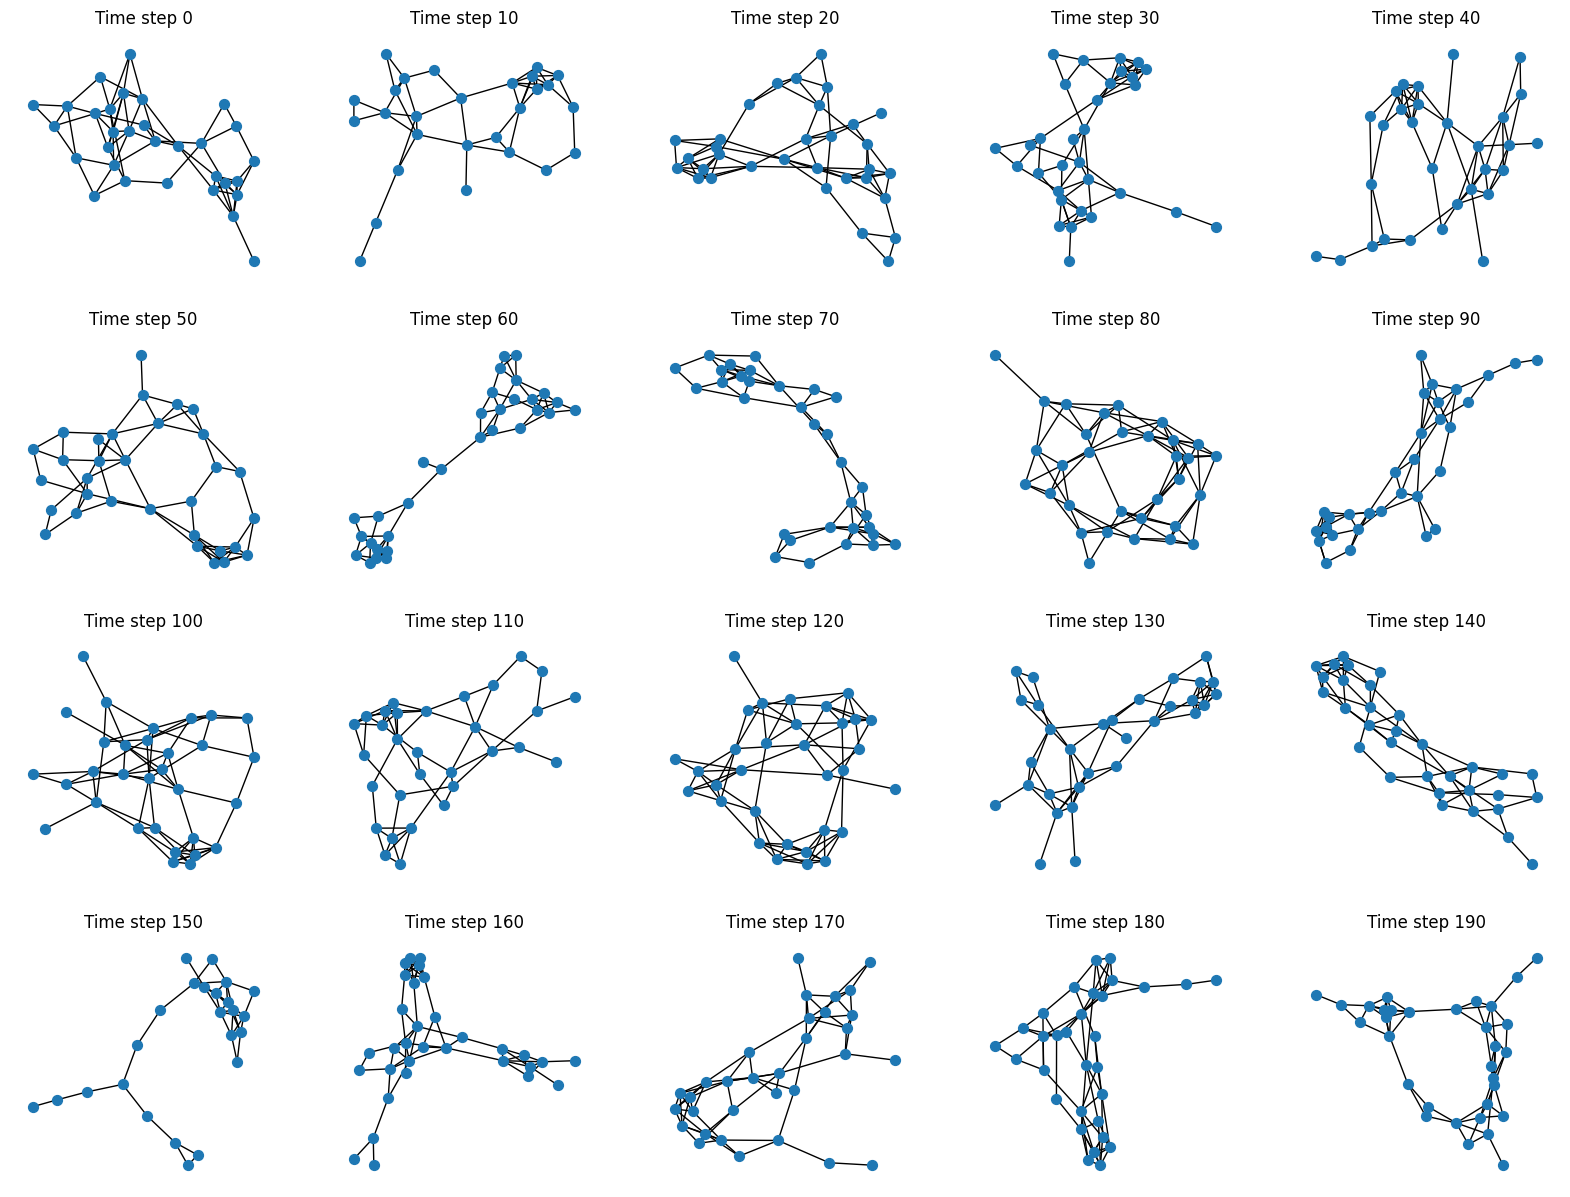

In [ ]:
# plot the graph at 10 timesteps in a rectangular subplots
fig, axs = plt.subplots(4, 5, figsize=(20, 15))
for i, ax in enumerate(axs.flat):
    j = i * 30
    graph = dynamic_graphs[j]
    pos = nx.spring_layout(graph)
    nx.draw(graph, pos, ax=ax, node_size=50, with_labels=False)
    ax.set_title(f"Time step {j}")



## Model

In [36]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split


In [37]:
def split_dataframes(df_dict, train_ratio=0.7):
    """
    Splits each DataFrame in df_dict into training and testing parts based on time indices.

    Returns:
        df_dict_train: Dictionary of training DataFrames.
        df_dict_test: Dictionary of testing DataFrames.
    """
    df_dict_train = {}
    df_dict_test = {}
    for key, df in df_dict.items():
        n_time_steps = len(df['traffic_flow'])
        train_size = int(n_time_steps * train_ratio)
        df_train = df.iloc[:train_size].copy()
        df_test = df.iloc[train_size:].copy()
        df_dict_train[key] = df_train
        df_dict_test[key] = df_test
    return df_dict_train, df_dict_test

def combine_node_data(X_dict, y_dict):
    """
    Combines data from all nodes.

    Returns:
        X_combined: Combined input sequences from all nodes.
        y_combined: Combined target sequences from all nodes.
    """
    X_list = []
    y_list = []
    for key in X_dict:
        X_list.append(X_dict[key])
        y_list.append(y_dict[key])
    X_combined = np.concatenate(X_list, axis=0)
    y_combined = np.concatenate(y_list, axis=0)
    return X_combined, y_combined

def convert_to_tensors_and_split(X, y, val_ratio=0.1, random_state=42):
    """
    Converts data to PyTorch tensors and splits into train and validation sets.

    Returns:
        X_train: Training input tensor.
        X_val: Validation input tensor.
        y_train: Training target tensor.
        y_val: Validation target tensor.
    """
    # Convert to PyTorch tensors
    X_tensor = torch.tensor(X, dtype=torch.float)
    y_tensor = torch.tensor(y, dtype=torch.float)

    # Split into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        X_tensor, y_tensor, test_size=val_ratio, random_state=random_state
    )
    return X_train, X_val, y_train, y_val

def prepare_pyg_data(X_train, y_train, X_val, y_val, X_test, y_test, edge_index, pred_horizon):
    """
    Prepares PyTorch Geometric Data objects for training, validation, and testing.

    Returns:
        train_data: Data object for training.
        val_data: Data object for validation.
        test_data: Data object for testing.
    """
    train_data = Data(x=X_train, edge_index=edge_index, y=y_train.view(-1, pred_horizon))
    val_data = Data(x=X_val, edge_index=edge_index, y=y_val.view(-1, pred_horizon))
    test_data = Data(x=X_test, edge_index=edge_index, y=y_test.view(-1, pred_horizon))
    return train_data, val_data, test_data


In [54]:
# Define GNN model
class Baseline(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.fc = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = self.fc(x)
        return x

class ImprovedBaseline(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout_rate=0.2):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = torch.nn.BatchNorm1d(hidden_channels)
        self.dropout = torch.nn.Dropout(p=dropout_rate)
        self.fc = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.bn1(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.bn2(x)
        x = self.dropout(x)
        x = self.fc(x)
        return x

class Baseline_updatet(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.fc = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = self.fc(x)
        return x


# Define GNN model
class TrafficGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.fc = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = self.fc(x)
        return x


In [39]:
# Prepare dynamic graphs and edge weights
dynamic_graphs, weight_time_series = create_dynamic_weight_graph(
    df_dict_train, lookback=lookback, pred_horizon=pred_horizon, adaptive_factor=0.2, max_degree=6
)

Processing time step 0/218
Processing time step 100/218
Processing time step 200/218


In [40]:
dynamic_graphs[0]

In [80]:
def create_sliding_window_data(df_dict, lookback, pred_horizon):
    """
    Create sliding window data for each node across all time steps.
    Args:
        df_dict (dict): Dictionary of DataFrames with traffic data.
        lookback (int): Number of time steps for the input window.
        pred_horizon (int): Number of time steps for the output window.
    Returns:
        X_dict: Dictionary of input feature arrays for each node.
        y_dict: Dictionary of target arrays for each node.
    """
    X_dict = {}
    y_dict = {}
    for key, df in df_dict.items():
        node_series = df['traffic_flow'].values
        X_node = []
        y_node = []
        for i in range(len(node_series) - lookback - pred_horizon + 1):
            X_node.append(node_series[i:i + lookback])  # Input: Lookback window
            y_node.append(node_series[i + lookback:i + lookback + pred_horizon])  # Output: Next step(s)
        X_dict[key] = np.array(X_node)
        y_dict[key] = np.array(y_node)
    return X_dict, y_dict

lookback = 50
pred_horizon = 1
# Prepare sliding window data
X_train_dict, y_train_dict = create_sliding_window_data(df_dict_train, lookback, pred_horizon)
X_test_dict, y_test_dict = create_sliding_window_data(df_dict_test, lookback, pred_horizon)

# Combine data from all nodes
X_train, y_train = combine_node_data(X_train_dict, y_train_dict)
X_test, y_test = combine_node_data(X_test_dict, y_test_dict)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float).to(device)
y_train = torch.tensor(y_train, dtype=torch.float).to(device)
X_test = torch.tensor(X_test, dtype=torch.float).to(device)
y_test = torch.tensor(y_test, dtype=torch.float).to(device)

# Initialize model, optimizer, and loss function
hc = 32*4  # Hidden channels
model = TrafficGCN(in_channels=lookback, hidden_channels=hc, out_channels=pred_horizon).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
criterion = torch.nn.MSELoss()

# Variables to store training info for later analysis
epoch_losses = []
last_batch_predictions_per_epoch = []
last_batch_actuals_per_epoch = []

# Training loop
model.train()
epochs = 300
error_count = 0
for epoch in range(epochs):
    total_loss = 0.0
    last_predictions = None
    last_actual = None
    
    # Iterate through each time step's graph
    for t, graph_t in enumerate(dynamic_graphs):
        # Skip graphs with no edges or only one node
        if graph_t.number_of_edges() == 0 or graph_t.number_of_nodes() <= 1:
            error_count += 1
            continue

        # Prepare edge_index
        node_mapping = {node: idx for idx, node in enumerate(graph_t.nodes())}
        edge_index = torch.tensor(
            [[node_mapping[edge[0]], node_mapping[edge[1]]] for edge in graph_t.edges()],
            dtype=torch.long
        ).t().contiguous().to(device)

        # Gather features for all nodes at time step t
        node_order = list(graph_t.nodes())
        aligned_features = []
        aligned_targets = []
        
        for node in node_order:
            aligned_features.append(X_train_dict[node][t])   # Shape: (lookback,)
            aligned_targets.append(y_train_dict[node][t])    # Shape: (pred_horizon,)

        aligned_features = torch.tensor(aligned_features, dtype=torch.float).to(device)
        aligned_targets = torch.tensor(aligned_targets, dtype=torch.float).to(device)

        # Now aligned_features is of shape (num_nodes, lookback)
        # and aligned_targets is (num_nodes, pred_horizon)
        train_data = Data(
            x=aligned_features,
            edge_index=edge_index,
            y=aligned_targets.view(-1, pred_horizon)
        ).to(device)

        # Forward pass
        optimizer.zero_grad()
        out = model(train_data)
        loss = criterion(out, train_data.y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        
        # Save the last batch predictions and actual values for this epoch
        last_predictions = out.detach().cpu().numpy()
        last_actual = train_data.y.detach().cpu().numpy()

    # Store epoch-level metrics
    epoch_loss = total_loss / len(dynamic_graphs) if len(dynamic_graphs) > 0 else 0.0
    epoch_losses.append(epoch_loss)
    
    # Store the last batch predictions and actuals from this epoch
    if last_predictions is not None and last_actual is not None:
        last_batch_predictions_per_epoch.append(last_predictions)
        last_batch_actuals_per_epoch.append(last_actual)

    # Print epoch loss
    if epoch % 1 == 0 and epoch > 0:
        print(f"Epoch {epoch}, Loss: {epoch_loss} Last Loss: {loss.item()}")


Epoch 1, Loss: 27182.6051814403 Last Loss: 5057.06884765625
Epoch 2, Loss: 25302.15021598886 Last Loss: 4631.33203125
Epoch 3, Loss: 23777.58547821395 Last Loss: 4230.87548828125
Epoch 4, Loss: 22497.920055214418 Last Loss: 4067.83203125
Epoch 5, Loss: 21440.229978421412 Last Loss: 4109.3876953125
Epoch 6, Loss: 20573.455897742457 Last Loss: 4280.42236328125
Epoch 7, Loss: 19869.74270297409 Last Loss: 4501.39404296875
Epoch 8, Loss: 19303.042007866257 Last Loss: 4700.4150390625
Epoch 9, Loss: 18845.32596005431 Last Loss: 4837.33154296875
Epoch 10, Loss: 18471.817826822262 Last Loss: 4910.384765625
Epoch 11, Loss: 18165.325913385514 Last Loss: 4921.9462890625
Epoch 12, Loss: 17911.650438737433 Last Loss: 4890.8564453125
Epoch 13, Loss: 17699.877989497752 Last Loss: 4827.73486328125
Epoch 14, Loss: 17521.400802481065 Last Loss: 4744.76953125
Epoch 15, Loss: 17368.47072086859 Last Loss: 4654.52490234375
Epoch 16, Loss: 17236.663171820685 Last Loss: 4571.3115234375
Epoch 17, Loss: 17122.24

KeyboardInterrupt: 

In [85]:
# Evaluate on test set (use the final graph for testing)
final_graph = dynamic_graphs[50]
node_mapping = {node: idx for idx, node in enumerate(final_graph.nodes())}
edge_index = torch.tensor(
    [[node_mapping[edge[0]], node_mapping[edge[1]]] for edge in final_graph.edges()],
    dtype=torch.long
).t().contiguous().to(device)

test_data = Data(x=X_test, edge_index=edge_index, y=y_test).to(device)
model.eval()
with torch.no_grad():
    test_out = model(test_data)
    test_loss = criterion(test_out, test_data.y)
    test_rmse = torch.sqrt(test_loss).item()
    test_mae = torch.mean(torch.abs(test_out - test_data.y)).item()

print(f"Test RMSE: {test_rmse}, Test MAE: {test_mae}")


Test RMSE: 84.17291259765625, Test MAE: 39.72250747680664
